In [1]:
import pandas as pd
file_path = 'CISO.xlsx'

In [2]:
# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)


In [5]:
df['Local time'] = pd.to_datetime(df['Local time'])

# Define the start and end dates for the range
start_date = '2019-01-01'
end_date = '2024-01-01'

#filter the DataFrame
filtered_df = df[(df['Local time'] >= start_date) & (df['Local time'] < end_date)]

In [6]:
column_names =['Adjusted D','Local time']

In [7]:
data = filtered_df[column_names]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 30720 to 74543
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Adjusted D  43824 non-null  float64       
 1   Local time  43824 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [10]:
# Set 'Time' column as the index
data.set_index('Local time', inplace=True)

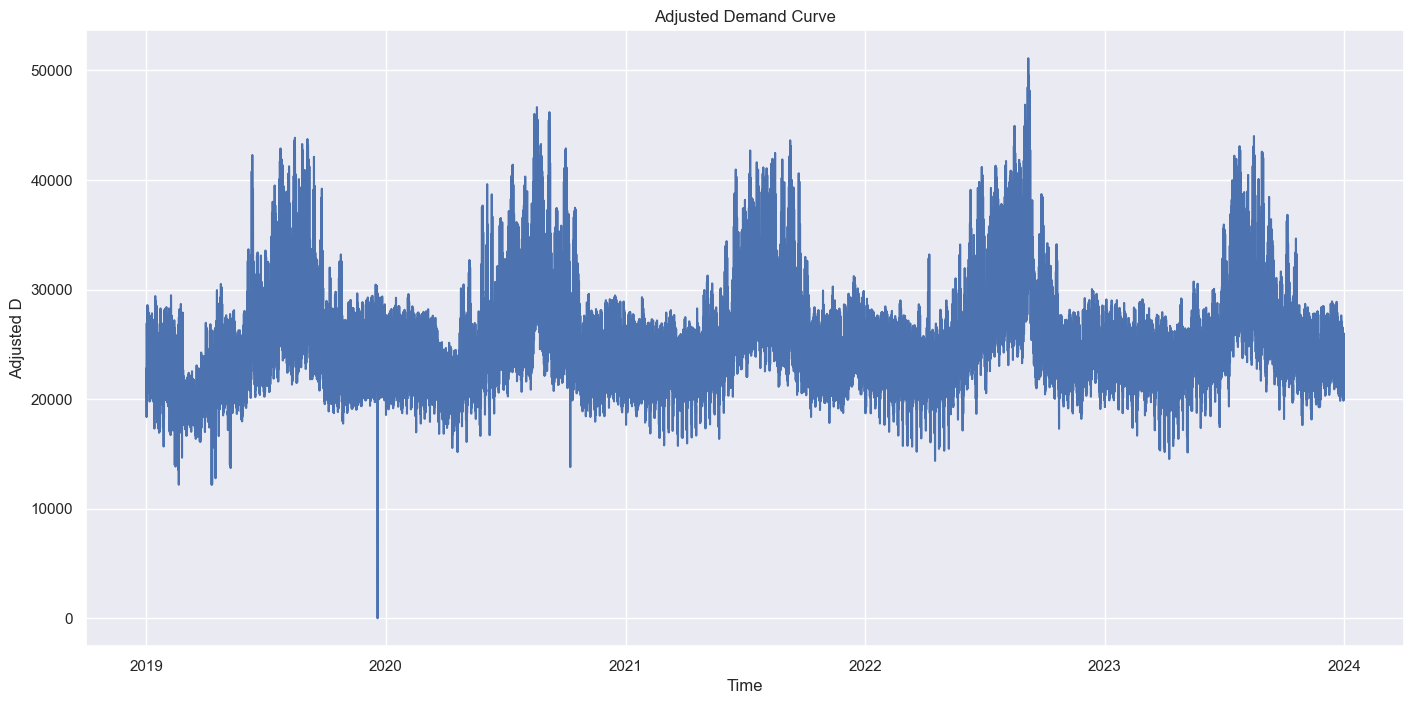

In [11]:
# Plot closing price

plt.figure(figsize=(17, 8))
plt.plot(data['Adjusted D'])
plt.title('Adjusted Demand Curve')
plt.ylabel('Adjusted D')
plt.xlabel('Time')
plt.grid(True)
plt.show()

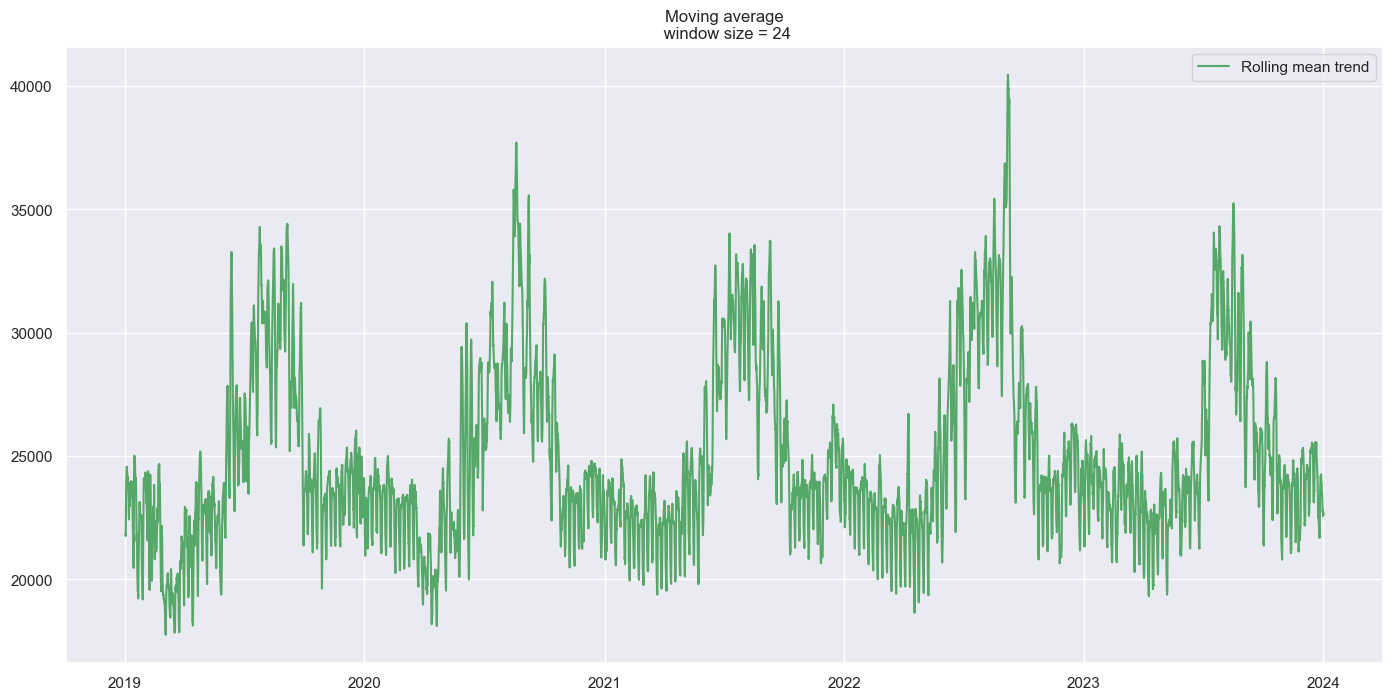

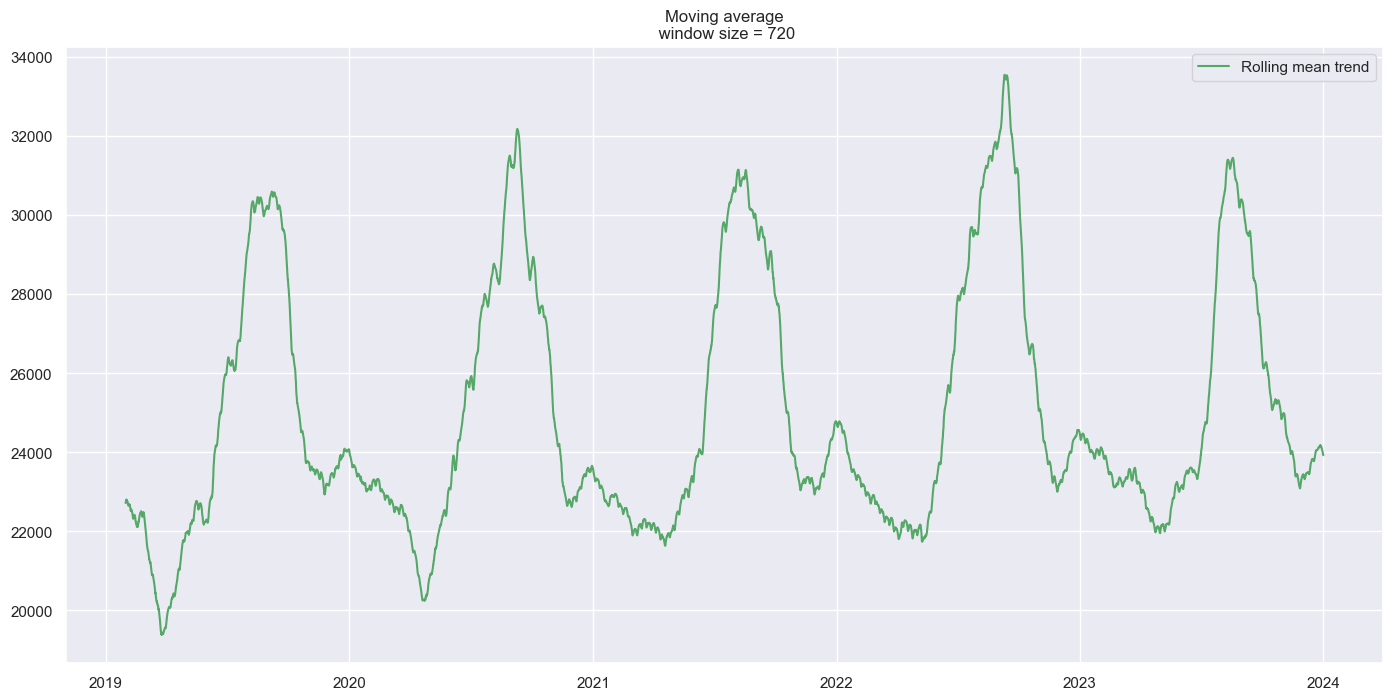

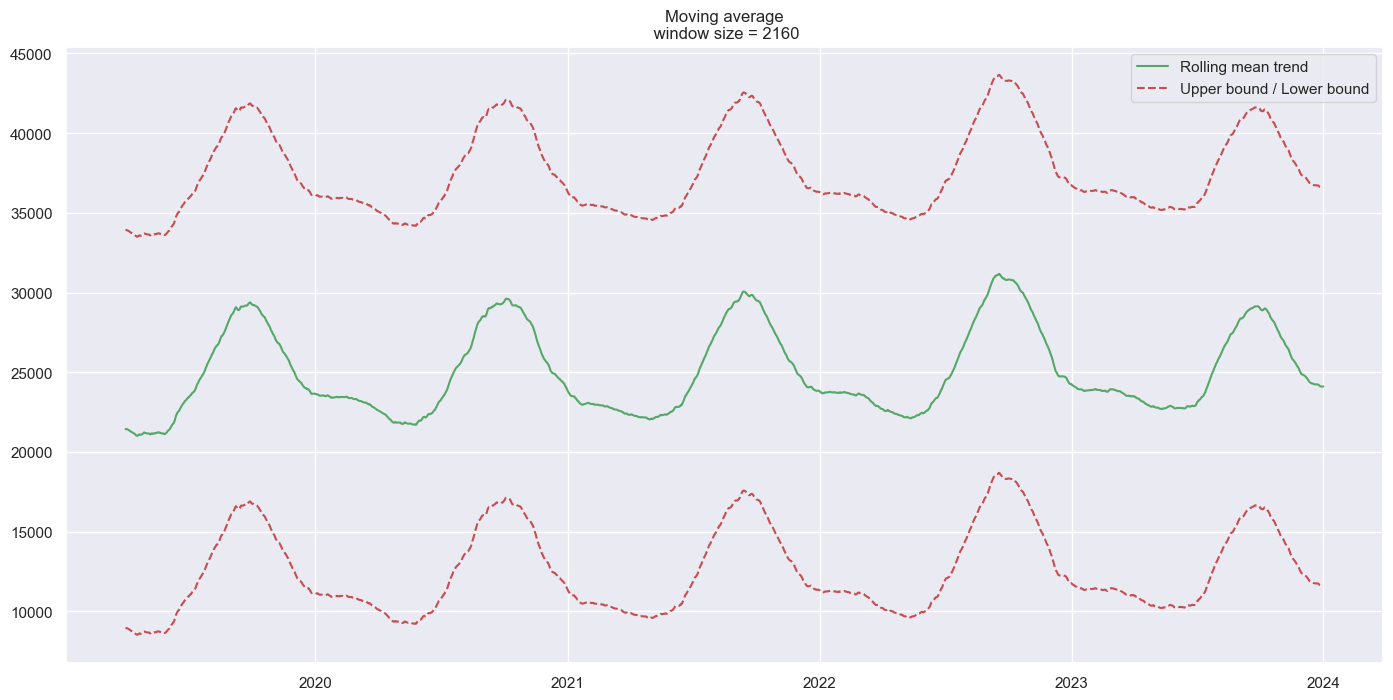

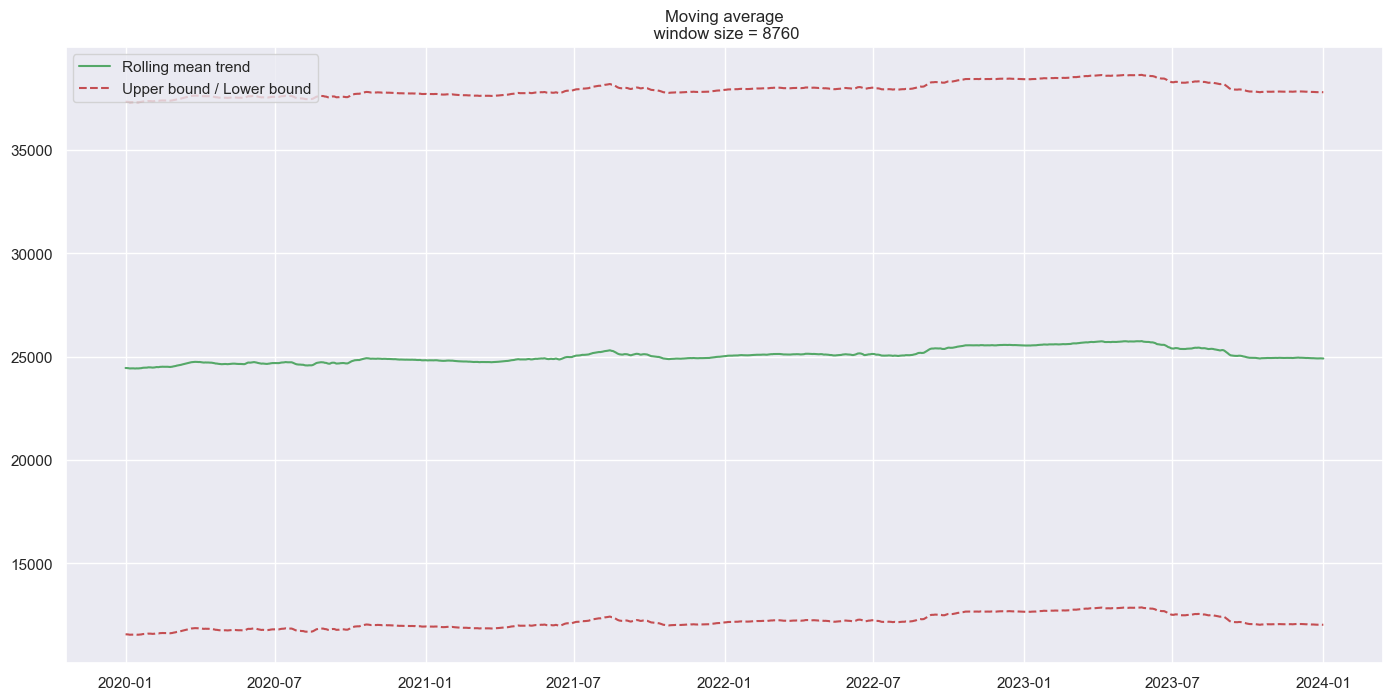

In [12]:

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    # plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 24 hours
plot_moving_average(data['Adjusted D'], 24)

#Smooth by the previous month (30 days)
plot_moving_average(data['Adjusted D'], 24*30)

#Smooth by previous quarter (90 days)
plot_moving_average(data['Adjusted D'], 24*90, plot_intervals=True)

#Smooth by previous year (365 days)
plot_moving_average(data['Adjusted D'], 24*365, plot_intervals=True)


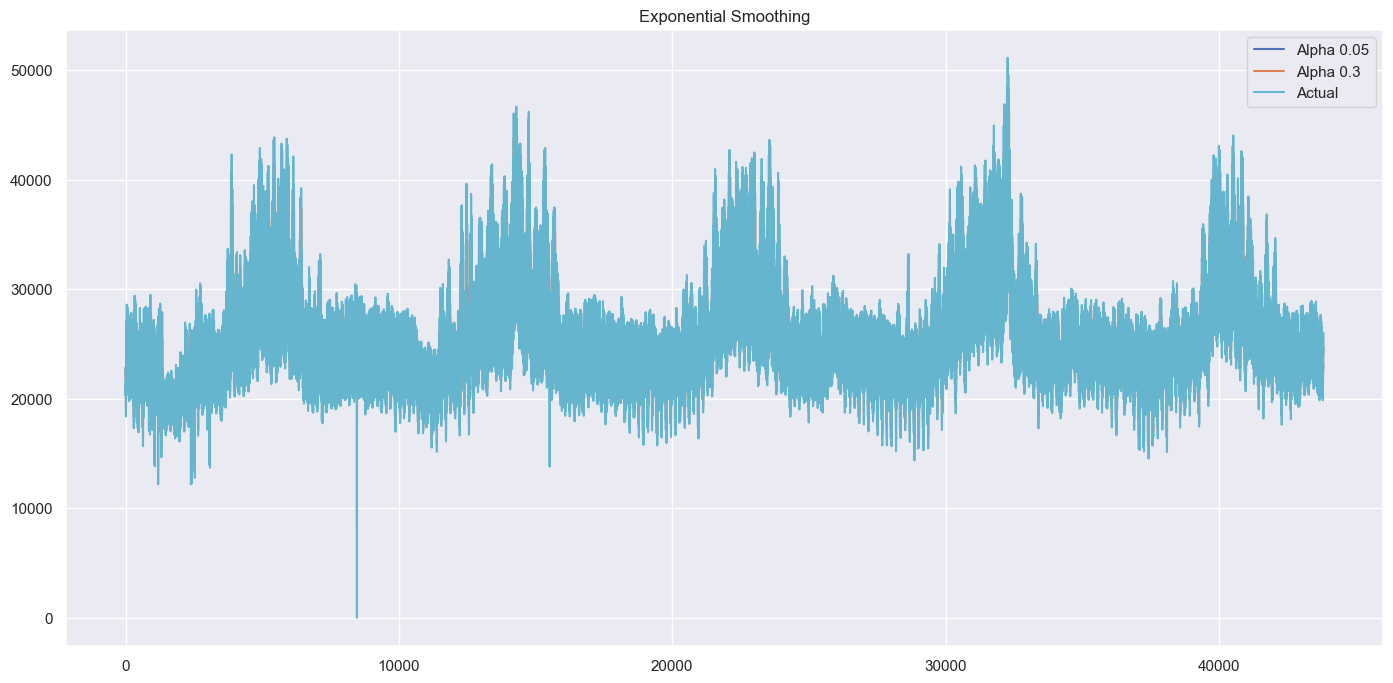

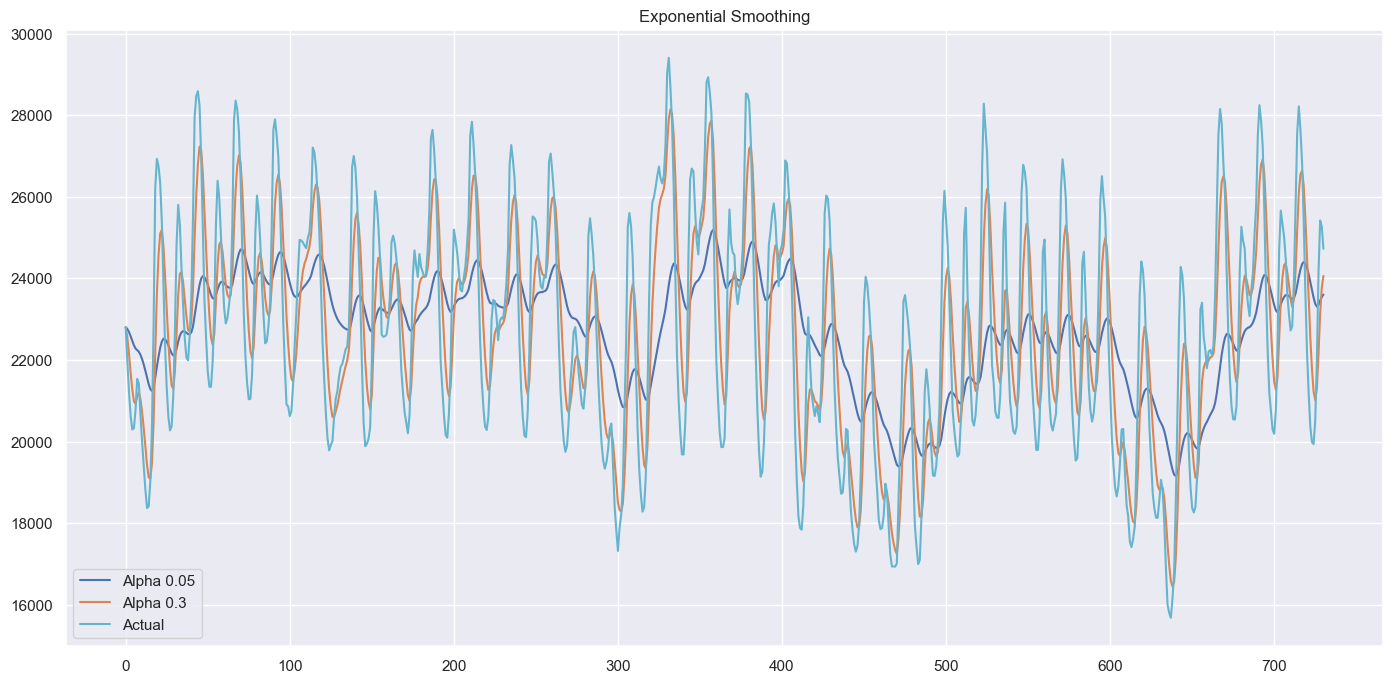

In [14]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data['Adjusted D'], [0.05, 0.3])
plot_exponential_smoothing(data['Adjusted D'].head(731), [0.05, 0.3])

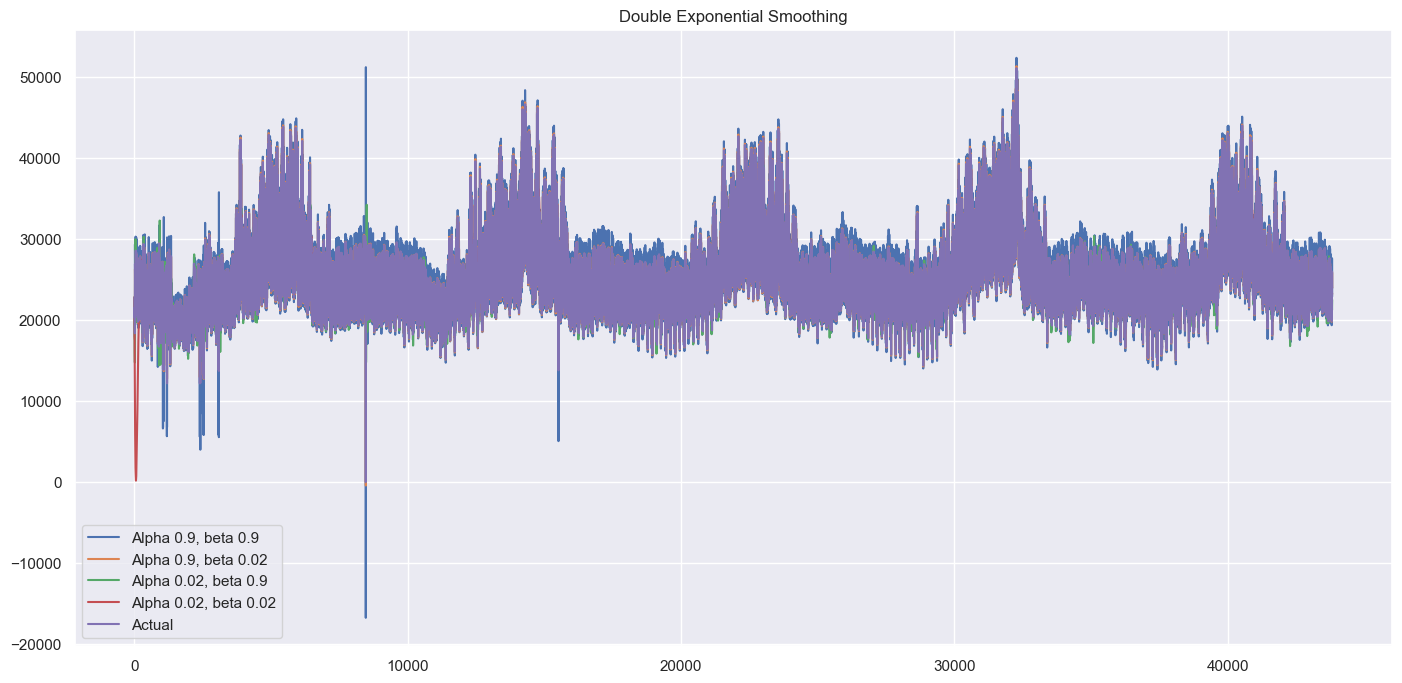

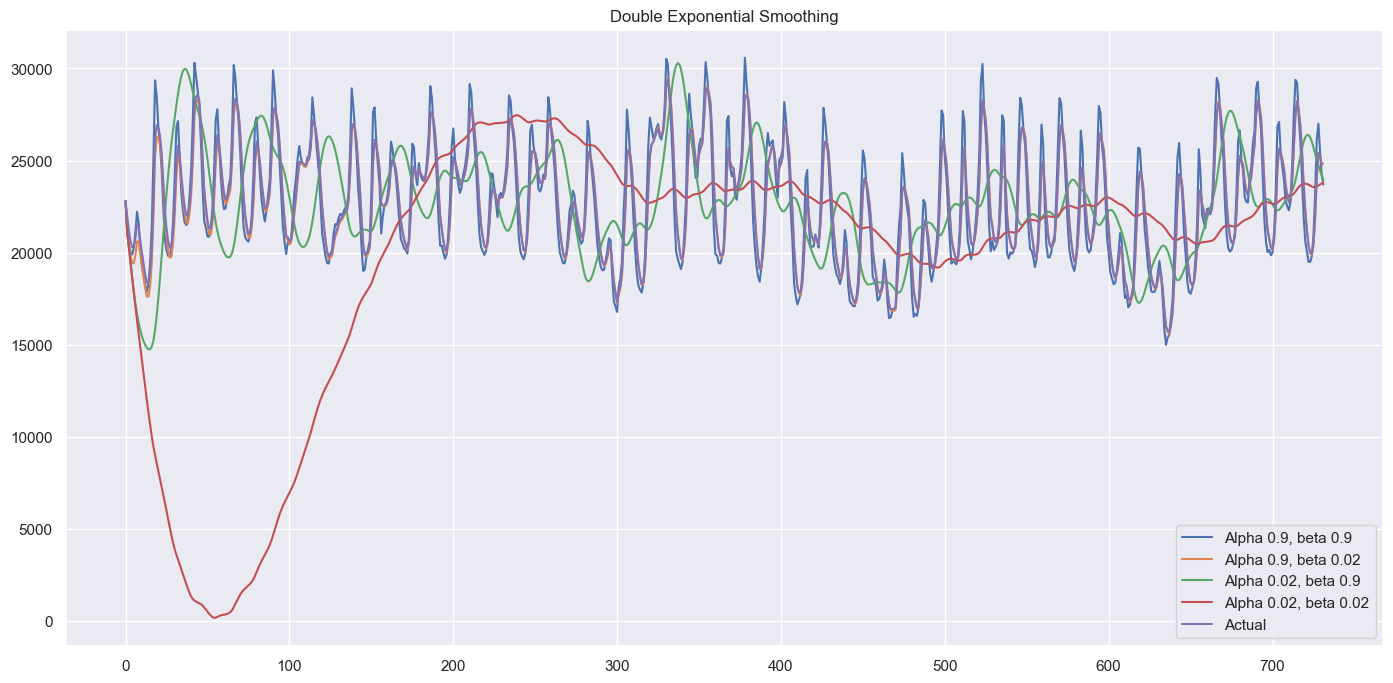

In [13]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(data['Adjusted D'], alphas=[0.9, 0.02], betas=[0.9, 0.02])
plot_double_exponential_smoothing(data['Adjusted D'].head(731), alphas=[0.9, 0.02], betas=[0.9, 0.02])

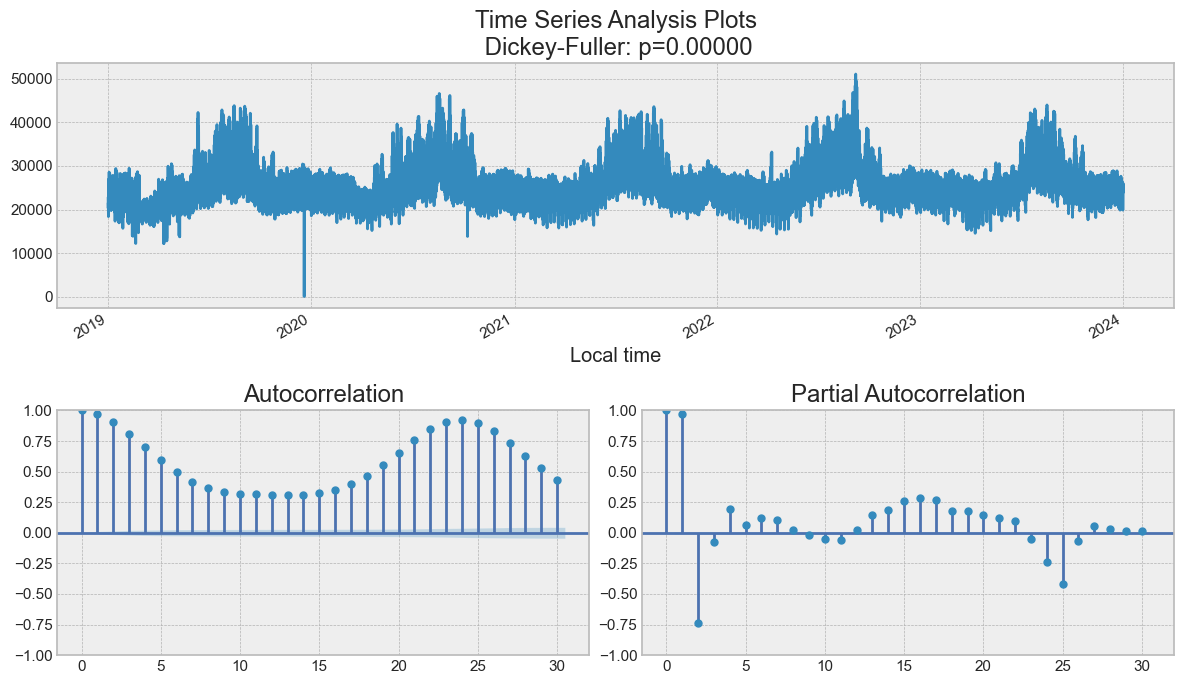

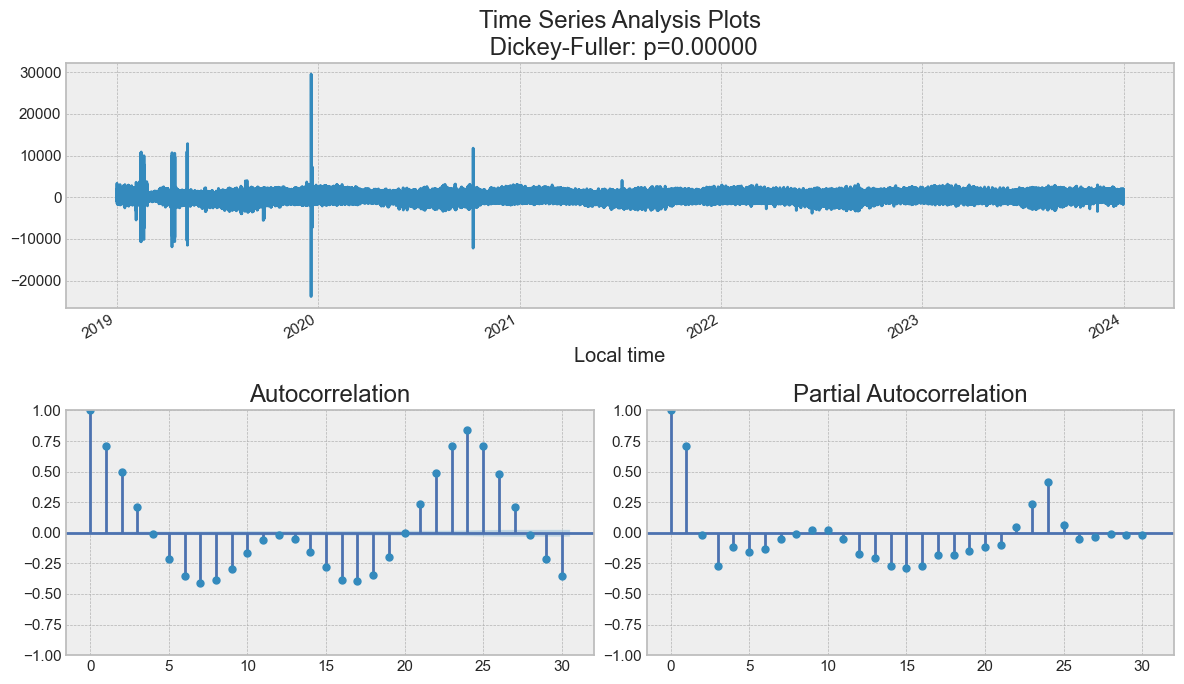

In [15]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data['Adjusted D'], lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data['Adjusted D'] - data['Adjusted D'].shift(1)

tsplot(data_diff[1:], lags=30)


data is already stationary according to the Dickey-Fuller test,not need to difference it further i.e  integration parameter (d) d=0  don't need to difference the data again before fitting the SARIMAX model.
data shows consistent patterns repeating every 24 hours, then your seasonal length would likely be 24 (for daily seasonality).
autoregression model AR(p) p would be 2 as we look at the partial autocorrelation plot and identify the lag after which most lags are not significant
moving average model MA(q) q would be 1  q which represents the biggest lag after which other lags are not significant on the autocorrelation plot.

Demand Froecast using LSTM

In [4]:
column_demand =['Local time','DF','Adjusted D']

In [5]:
df_demand = filtered_df[column_demand]

In [6]:
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 30720 to 74543
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Local time  43824 non-null  datetime64[ns]
 1   DF          43824 non-null  float64       
 2   Adjusted D  43824 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.3 MB


In [7]:
df_demand.head()

,Local time,DF,Adjusted D
30720,2019-01-01 00:00:00,23436.0,22803.0
30721,2019-01-01 01:00:00,22362.0,21965.0
30722,2019-01-01 02:00:00,21444.0,21216.0
30723,2019-01-01 03:00:00,20803.0,20631.0
30724,2019-01-01 04:00:00,20416.0,20299.0


In [9]:
import numpy as np
mape = np.mean(np.abs((df_demand['Adjusted D'] - df_demand['DF']) / df_demand['Adjusted D'])) * 100
print('MAPE of the forecasted data present in DataFrame:', mape)

MAPE of the forecasted data present in DataFrame: 8.923152765707808


In [10]:
temp = df_demand.copy() # make temporary copy of dataframe
dataset = temp['Adjusted D'].dropna().values # numpy.ndarray of the actual load
dataset = dataset.astype('float32') 
dataset = np.reshape(dataset, (-1, 1)) # reshape to one feature; required for the models
dataset

array([[22803.],
       [21965.],
       [21216.],
       ...,
       [25007.],
       [24317.],
       [23918.]], dtype=float32)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)) # Min Max scaler
dataset = scaler.fit_transform(dataset) # fit and transform the dataset


In [13]:
dataset

array([[0.44605598],
       [0.42965356],
       [0.41499317],
       ...,
       [0.48919556],
       [0.47568998],
       [0.46788022]], dtype=float32)

In [14]:
# Train and Test splits
train_size = int(len(dataset) * 0.80) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [15]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [16]:
look_back = 25 # timesteps to lookback for predictions
X_train, trainY = create_dataset(train, look_back)
X_test, testY = create_dataset(test, look_back)

In [17]:
len(X_train)
X_train
#(batch_size, timesteps, features)

array([[0.44605598, 0.42965356, 0.41499317, ..., 0.49704444, 0.4669407 ,
        0.43671954],
       [0.42965356, 0.41499317, 0.4035428 , ..., 0.4669407 , 0.43671954,
        0.4169505 ],
       [0.41499317, 0.4035428 , 0.39704445, ..., 0.43671954, 0.4169505 ,
        0.40317088],
       ...,
       [0.49412802, 0.4925426 , 0.48459584, ..., 0.4637894 , 0.46594247,
        0.47234294],
       [0.4925426 , 0.48459584, 0.48348016, ..., 0.46594247, 0.47234294,
        0.47048348],
       [0.48459584, 0.48348016, 0.49733806, ..., 0.47234294, 0.47048348,
        0.46962225]], dtype=float32)

In [18]:
trainY

array([0.4169505 , 0.40317088, 0.3965551 , ..., 0.47048348, 0.46962225,
       0.48017225], dtype=float32)

In [19]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print("Shapes: \nTraining set: {}, Testing set: {}".format(X_train.shape, X_test.shape))
print("Sample from training set: \n{}".format(X_train[0]))

Shapes: 
Training set: (35033, 1, 25), Testing set: (8739, 1, 25)
Sample from training set: 
[[0.44605598 0.42965356 0.41499317 0.4035428  0.39704445 0.39755335
  0.40647876 0.42123705 0.41922098 0.4038168  0.39097673 0.37944806
  0.3680564  0.3593071  0.36012918 0.37216678 0.39776865 0.44717166
  0.5126444  0.5267959  0.5233901  0.51546293 0.49704444 0.4669407
  0.43671954]]


AutoRegressive
An autoregressive (AR) model predicts future behavior based on past behavior. The process is basically a linear regression of the data in the current series against one or more past values in the same series.

In [20]:
from statsmodels.tsa.ar_model import  AutoReg
lags = 25
model = AutoReg(train,lags=lags)
model_fit = model.fit()

In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout,Dense
from sklearn.metrics import mean_squared_error,mean_absolute_error, accuracy_score, classification_report


In [23]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Test Mean Absolute Error: 3013.151472614155
Test Root Mean Squared Error: 4121.641134074582


In [24]:
Y_test

array([[26468.],
       [26047.],
       [25240.],
       ...,
       [25007.],
       [24317.],
       [23918.]], dtype=float32)

In [25]:
test_predict

array([[26141.17859608],
       [26101.21156623],
       [25773.58289138],
       ...,
       [24965.1645046 ],
       [24965.16452434],
       [24965.1645325 ]])

In [26]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

Testing MAPE: 11.915021173871173


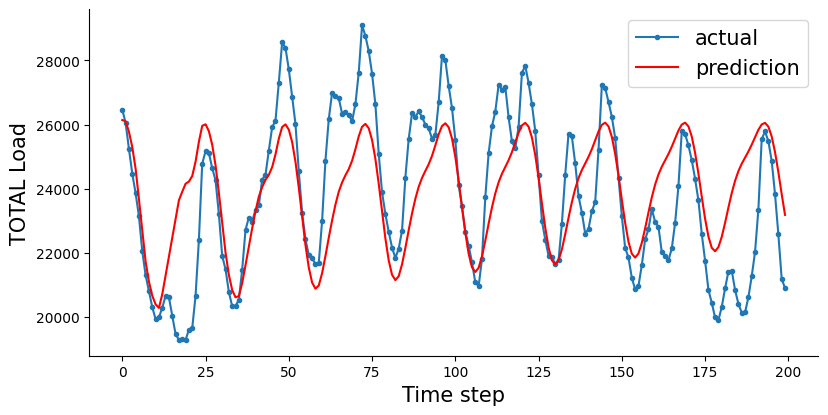

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

Moving Average
The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks or any time period the trader chooses. We are taking moving average of 25 hours hence we can use the data we prepared for LSTM.

In [30]:
test_predict = np.mean(X_test, axis=2)
print('Test Mean Absolute Error:', mean_absolute_error(testY, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(testY, test_predict)))

Test Mean Absolute Error: 0.04286583
Test Root Mean Squared Error: 0.053635698


In [31]:
testY

array([0.4923077 , 0.4912116 , 0.48201215, ..., 0.5049521 , 0.48919556,
       0.47568998], dtype=float32)

In [32]:
Y_test_value = scaler.inverse_transform(testY.reshape(-1, 1))

In [33]:
Y_test_value

array([[25166.],
       [25110.],
       [24640.],
       ...,
       [25812.],
       [25007.],
       [24317.]], dtype=float32)

In [34]:
test_predict_value = scaler.inverse_transform(test_predict.reshape(-1, 1))

In [35]:
test_predict_value

array([[21580.879],
       [21528.8  ],
       [21491.322],
       ...,
       [22826.803],
       [22833.64 ],
       [22810.559]], dtype=float32)

In [36]:
mape = np.mean(np.abs((Y_test_value - test_predict_value) / Y_test_value)) * 100
print("Testing MAPE: {}".format(mape))

Testing MAPE: 8.662478625774384


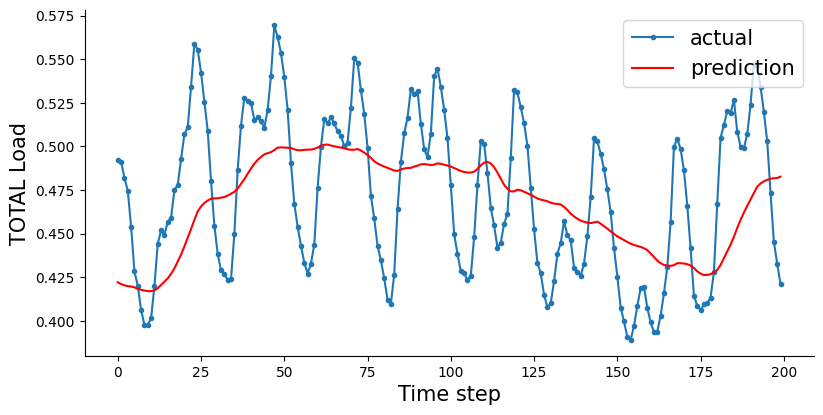

In [37]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, testY[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

ARMA
An ARMA model, or Autoregressive Moving Average model, is used to describe weakly stationary stochastic time series in terms of two polynomials. The first of these polynomials is for autoregression, the second for the moving average.

In [38]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'train' is your training data
order = (2, 0, 1)  # ARIMA order: (p, d, q)
model = ARIMA(train, order=order)
model_fit = model.fit()


In [39]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Test Mean Absolute Error: 3058.6738609053887
Test Root Mean Squared Error: 4146.076288010142


In [40]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

Testing MAPE: 12.11620191021095


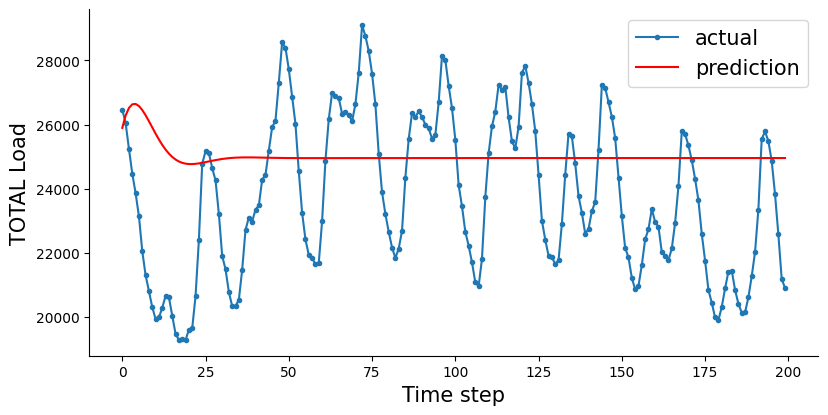

In [41]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

LSTM
Long short-term memory is an artificial recurrent neural network architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points, but also entire sequences of data

In [42]:
temp = df_demand.copy() # make temporary copy of dataframe
dataset = temp['Adjusted D'].dropna().values # numpy.ndarray of the actual load
dataset = dataset.astype('float32') 
dataset = np.reshape(dataset, (-1, 1)) # reshape to one feature; required for the models
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [43]:
dataset

array([[0.44605598],
       [0.42965356],
       [0.41499317],
       ...,
       [0.48919556],
       [0.47568998],
       [0.46788022]], dtype=float32)

In [44]:
X_test

array([[[0.51779217, 0.5095518 , 0.49375612, ..., 0.4038951 ,
         0.43814838, 0.48471326]],

       [[0.5095518 , 0.49375612, 0.4786064 , ..., 0.43814838,
         0.48471326, 0.4923077 ]],

       [[0.49375612, 0.4786064 , 0.46670583, ..., 0.48471326,
         0.4923077 , 0.4912116 ]],

       ...,

       [[0.50160503, 0.50048935, 0.49712273, ..., 0.45314154,
         0.47218636, 0.5086123 ]],

       [[0.50048935, 0.49712273, 0.4932668 , ..., 0.47218636,
         0.5086123 , 0.5049521 ]],

       [[0.49712273, 0.4932668 , 0.4828538 , ..., 0.5086123 ,
         0.5049521 , 0.48919556]]], dtype=float32)

In [45]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=70, validation_data=(X_test, Y_test),verbose=1, shuffle=False)

model.summary()

Epoch 1/200
501/501 [==============================] - 3s 3ms/step - loss: 0.0047 - val_loss: 8.2048e-04
Epoch 2/200
501/501 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 5.5720e-04
Epoch 3/200
501/501 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/200
501/501 [==============================] - 1s 2ms/step - loss: 9.6240e-04 - val_loss: 0.0011
Epoch 5/200
501/501 [==============================] - 1s 2ms/step - loss: 8.1487e-04 - val_loss: 6.3846e-04
Epoch 6/200
501/501 [==============================] - 1s 2ms/step - loss: 7.1368e-04 - val_loss: 4.8807e-04
Epoch 7/200
501/501 [==============================] - 1s 2ms/step - loss: 6.3715e-04 - val_loss: 3.7536e-04
Epoch 8/200
501/501 [==============================] - 1s 2ms/step - loss: 5.6009e-04 - val_loss: 3.7433e-04
Epoch 9/200
501/501 [==============================] - 1s 2ms/step - loss: 5.0719e-04 - val_loss: 2.1072e-04
Epoch 10/200
501/501 [=================

In [46]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

274/274 [==============================] - 0s 767us/step
Train Mean Absolute Error: 329.29256905978883
Train Root Mean Squared Error: 574.5066335749399
Test Mean Absolute Error: 340.8772263839703
Test Root Mean Squared Error: 446.8247168093195


In [47]:
test_predict

array([[25092.873],
       [24980.973],
       [24565.816],
       ...,
       [26337.656],
       [25893.178],
       [24704.838]], dtype=float32)

In [48]:
Y_test

array([[25165.99904261, 25109.99931546, 24639.99991971, ...,
        25812.00040853, 25006.99995326, 24316.99999805]])

In [49]:
mape_train = np.mean(np.abs((Y_train[0] - train_predict[:,0]) / Y_train[0])) * 100
mape_test = np.mean(np.abs((Y_test[0] - test_predict[:,0]) / Y_test[0])) * 100

print("Train MAPE: {}, Test MAPE: {}".format(mape_train, mape_test))

Train MAPE: 6.708990578052999, Test MAPE: 1.359931111005935


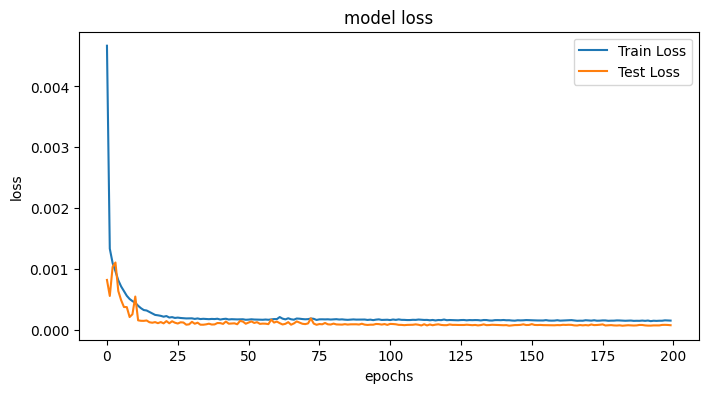

In [50]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

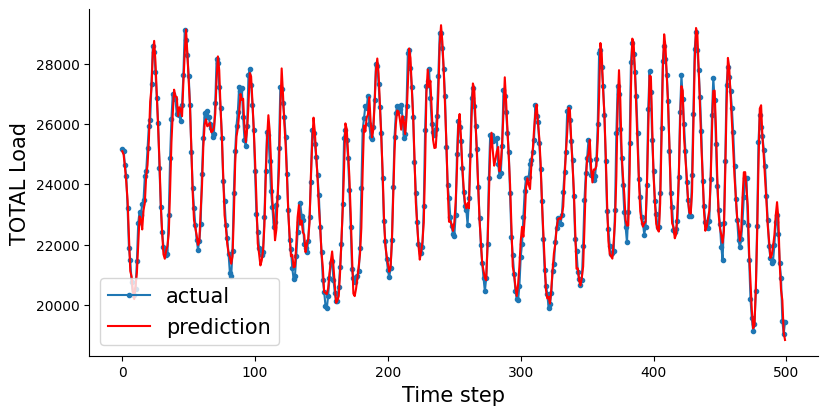

In [54]:
idx = 500
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [53]:
# Get forecast of 10 years or 120 months steps ahead in future
# forecast = model.get_forecast(steps= 120)

In [56]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout

In [69]:
df_demand.isnull().sum()

Local time    0
DF            0
Adjusted D    0
dtype: int64

In [89]:
# close_data = df['Adjusted D'].values
# close_data = close_data.reshape((-1,1))

# split_percent = 0.80
# split = int(split_percent*len(close_data))

# close_train = close_data[:split]
# close_test = close_data[split:]

# date_train = df['Local time'][:split]
# date_test = df['Local time'][split:]

# print(len(close_train))
# print(len(close_test))
scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = np.reshape(dataset, (-1, 1)) # reshape to one feature; required for the models
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)

close_data = df_demand['Adjusted D'].values
close_data = close_data.reshape((-1,1))
close_data = scaler.fit_transform(close_data)

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df_demand['Local time'][:split]
date_test = df_demand['Local time'][split:]

print(len(close_train))
print(len(close_test))

35059
8765


In [93]:
close_data

array([[0.44605598],
       [0.42965355],
       [0.41499315],
       ...,
       [0.48919554],
       [0.47568996],
       [0.46788021]])

In [94]:
look_back = 25

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=70)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=70)

In [95]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# history = model.fit(X_train, Y_train, epochs=200, batch_size=70, validation_data=(X_test, Y_test),verbose=1, shuffle=False)
model = Sequential()
model.add(LSTM(100,input_shape=(look_back,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

num_epochs = 20
history= model.fit(train_generator, epochs=num_epochs,validation_data=test_generator,verbose=1, shuffle=False)

Epoch 1/20
501/501 [==============================] - 12s 20ms/step - loss: 0.0055 - val_loss: 0.0021
Epoch 2/20
501/501 [==============================] - 9s 18ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 3/20
501/501 [==============================] - 9s 18ms/step - loss: 0.0013 - val_loss: 8.8400e-04
Epoch 4/20
501/501 [==============================] - 9s 18ms/step - loss: 0.0010 - val_loss: 7.4486e-04
Epoch 5/20
501/501 [==============================] - 9s 18ms/step - loss: 8.6549e-04 - val_loss: 5.2345e-04
Epoch 6/20
501/501 [==============================] - 9s 18ms/step - loss: 7.6054e-04 - val_loss: 5.1735e-04
Epoch 7/20
501/501 [==============================] - 9s 18ms/step - loss: 6.7370e-04 - val_loss: 4.2135e-04
Epoch 8/20
501/501 [==============================] - 9s 18ms/step - loss: 5.9468e-04 - val_loss: 3.4721e-04
Epoch 9/20
501/501 [==============================] - 9s 18ms/step - loss: 5.2381e-04 - val_loss: 2.8280e-04
Epoch 10/20
501/501 [=====================

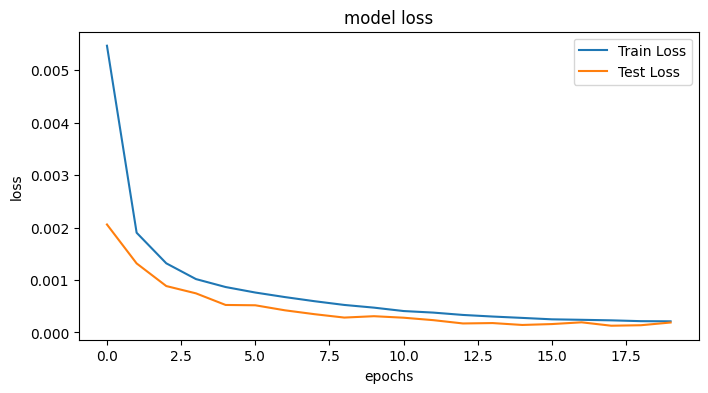

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [97]:
prediction = model.predict(test_generator)

125/125 [==============================] - 1s 6ms/step


In [98]:
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))


In [100]:
def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        # train_predict = scaler.inverse_transform(train_predict)
        # out = scaler.inverse_transform(out)
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df_demand['Local time'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 48
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 17ms/step


In [101]:
(forecast)

array([0.46788021, 0.45090926, 0.43095359, 0.41294193, 0.3992916 ,
       0.39188075, 0.39114898, 0.39595595, 0.40385461, 0.41187778,
       0.41751158, 0.41938367, 0.41766208, 0.41407701, 0.41156292,
       0.41258246, 0.41864598, 0.42978245, 0.44458854, 0.46019518,
       0.47281244, 0.47947174, 0.47928956, 0.47223321, 0.45951512,
       0.44370976, 0.42818996, 0.41582969, 0.40843239, 0.40650123,
       0.40917364, 0.41443419, 0.41966054, 0.42244217, 0.42141455,
       0.41674376, 0.41003409, 0.40373749, 0.40036622, 0.40179303,
       0.40877086, 0.42067224, 0.43549719, 0.45023918, 0.46164715,
       0.46720403, 0.4659265 , 0.45862415, 0.44754326])

In [107]:
forecastout = forecast.reshape((-1, 1))


In [108]:
forecastout = scaler.inverse_transform(forecastout)

In [109]:
forecastout

array([[23918.        ],
       [23050.95393682],
       [22031.41901845],
       [21111.20334053],
       [20413.80808705],
       [20035.18755102],
       [19997.80161464],
       [20243.38948661],
       [20646.93195009],
       [21056.83583909],
       [21344.66674352],
       [21440.3119486 ],
       [21352.3558768 ],
       [21169.19463152],
       [21040.74956322],
       [21092.83773148],
       [21402.62301469],
       [21971.58538067],
       [22728.02860999],
       [23525.37193799],
       [24169.98776251],
       [24510.21135533],
       [24500.90369755],
       [24140.39449626],
       [23490.62771374],
       [22683.1316846 ],
       [21890.2252149 ],
       [21258.73877579],
       [20880.81102306],
       [20782.14802349],
       [20918.68114644],
       [21187.44300032],
       [21454.45690864],
       [21596.57036299],
       [21544.06956995],
       [21305.43846035],
       [20962.64167243],
       [20640.94812953],
       [20468.71002132],
       [20541.60605007],


In [110]:
# Define the start and end dates for the range
start_date = '2024-01-01'
end_date = '2024-01-31'

#filter the DataFrame
df_Jan24 = df[(df['Local time'] >= start_date) & (df['Local time'] <= end_date)]
column_demand =['Local time','DF','Adjusted D']
df_Jan24 = df_Jan24[column_demand]

In [113]:
df_Jan24=df_Jan24.head(49)

In [118]:
df_Jan24['Model_forecast']=forecastout

C:\Users\USER\AppData\Local\Temp\ipykernel_560\2544081355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Jan24['Model_forecast']=forecastout


In [119]:
df_Jan24

,Local time,DF,Adjusted D,Model_forecast
74544,2024-01-01 00:00:00,22052.0,23066.0,23918.000000
74545,2024-01-01 01:00:00,21350.0,22365.0,23050.953937
74546,2024-01-01 02:00:00,20538.0,21604.0,22031.419018
74547,2024-01-01 03:00:00,20008.0,21007.0,21111.203341
74548,2024-01-01 04:00:00,19605.0,20402.0,20413.808087
74549,2024-01-01 05:00:00,19635.0,20119.0,20035.187551
74550,2024-01-01 06:00:00,20003.0,19740.0,19997.801615
74551,2024-01-01 07:00:00,20690.0,20059.0,20243.389487
74552,2024-01-01 08:00:00,21006.0,20697.0,20646.931950
74553,2024-01-01 09:00:00,20285.0,21060.0,21056.835839


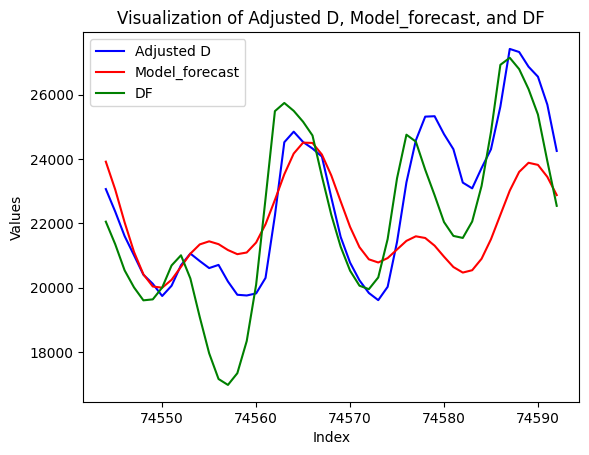

In [120]:
# Plotting Adjusted D with blue color
plt.plot(df_Jan24['Adjusted D'], color='blue', label='Adjusted D')

# Plotting Model_forecast with red color
plt.plot(df_Jan24['Model_forecast'], color='red', label='Model_forecast')

# Plotting DF with green color
plt.plot(df_Jan24['DF'], color='green', label='DF')

plt.xlabel('Index')  # Assuming the x-axis represents the index of the DataFrame
plt.ylabel('Values')
plt.title('Visualization of Adjusted D, Model_forecast, and DF')
plt.legend()  # Adding legend to differentiate the lines
plt.show()

In [123]:
# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(df_Jan24['Adjusted D'] - df_Jan24['DF']))

# Calculate Mean Squared Error (MSE)
mse = np.mean((df_Jan24['Adjusted D'] - df_Jan24['DF'])**2)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 1219.6734693877552
Mean Squared Error (MSE): 2328169.7959183673
Root Mean Squared Error (RMSE): 1525.834131194596


In [122]:
# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(df_Jan24['Adjusted D'] - df_Jan24['Model_forecast']))

# Calculate Mean Squared Error (MSE)
mse = np.mean((df_Jan24['Adjusted D'] - df_Jan24['Model_forecast'])**2)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 1491.477052736039
Mean Squared Error (MSE): 3884493.9933017995
Root Mean Squared Error (RMSE): 1970.9119699524379
